In [1]:

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)


from scipy import stats


import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RepeatedKFold


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:

df = pd.read_csv("Expanded_data_with_more_features.csv")

df.head(10)

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
5,5,female,group B,associate's degree,standard,none,married,regularly,yes,1.0,school_bus,5 - 10,73,84,79
6,6,female,group B,some college,standard,completed,widowed,never,no,1.0,private,5 - 10,85,93,89
7,7,male,group B,some college,free/reduced,none,married,sometimes,yes,1.0,private,> 10,41,43,39
8,8,male,group D,high school,free/reduced,completed,single,sometimes,no,3.0,private,> 10,65,64,68
9,9,female,group B,high school,free/reduced,none,married,regularly,yes,NaN,private,< 5,37,59,50


In [17]:
df['NrSiblings'] = pd.to_numeric(df['NrSiblings'], downcast='integer', errors='coerce')
df['NrSiblings'] = df['NrSiblings'].astype('Int64')

df['NrSiblings'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 30641 entries, 0 to 30640
Series name: NrSiblings
Non-Null Count  Dtype
--------------  -----
29069 non-null  Int64
dtypes: Int64(1)
memory usage: 269.4 KB


In [18]:
df = df.drop('Unnamed: 0', axis=1)

In [19]:

df.rename(columns={'Gender':'gender',
                   'EthnicGroup':'ethnic_group',
                   'ParentEduc':'parents_education',
                   'LunchType':'lunch_type',
                   'TestPrep':'test_preparation',
                   'ParentMaritalStatus':'parent_marital_status',
                   'PracticeSport':'practice_sports',
                   'IsFirstChild':'is_first_child',
                   'NrSiblings':'number_of_siblings',
                   'TransportMeans':'transport_means',
                   'WklyStudyHours':'weekly_study_hours',
                   'MathScore':'math_score',
                   'ReadingScore':'reading_score',
                   'WritingScore':'writing_score'}, inplace=True)

df.head()

,gender,ethnic_group,parents_education,lunch_type,test_preparation,parent_marital_status,practice_sports,is_first_child,number_of_siblings,transport_means,weekly_study_hours,math_score,reading_score,writing_score
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0,school_bus,5 - 10,76,78,75


In [21]:

df1b = df.copy()

df1b = df1b.dropna(subset=['ethnic_group','parents_education','test_preparation','number_of_siblings','transport_means'], axis=0)

df1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21721 entries, 2 to 30640
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 21721 non-null  object
 1   ethnic_group           21721 non-null  object
 2   parents_education      21721 non-null  object
 3   lunch_type             21721 non-null  object
 4   test_preparation       21721 non-null  object
 5   parent_marital_status  20883 non-null  object
 6   practice_sports        21298 non-null  object
 7   is_first_child         21094 non-null  object
 8   number_of_siblings     21721 non-null  Int64 
 9   transport_means        21721 non-null  object
 10  weekly_study_hours     21038 non-null  object
 11  math_score             21721 non-null  int64 
 12  reading_score          21721 non-null  int64 
 13  writing_score          21721 non-null  int64 
dtypes: Int64(1), int64(3), object(10)
memory usage: 2.5+ MB


In [22]:
df1b['parent_marital_status'] = df1b['parent_marital_status'].fillna(df1b['parent_marital_status'].mode()[0])
df1b['practice_sports'] = df1b['practice_sports'].fillna(df1b['practice_sports'].mode()[0])
df1b['weekly_study_hours'] = df1b['weekly_study_hours'].fillna(df1b['weekly_study_hours'].mode()[0])


df1b['is_first_child'] = df1b['is_first_child'].fillna(df1b['is_first_child'].mode()[0])

df1b.isnull().sum()

gender                   0
ethnic_group             0
parents_education        0
lunch_type               0
test_preparation         0
parent_marital_status    0
practice_sports          0
is_first_child           0
number_of_siblings       0
transport_means          0
weekly_study_hours       0
math_score               0
reading_score            0
writing_score            0
dtype: int64

In [23]:
df1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21721 entries, 2 to 30640
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 21721 non-null  object
 1   ethnic_group           21721 non-null  object
 2   parents_education      21721 non-null  object
 3   lunch_type             21721 non-null  object
 4   test_preparation       21721 non-null  object
 5   parent_marital_status  21721 non-null  object
 6   practice_sports        21721 non-null  object
 7   is_first_child         21721 non-null  object
 8   number_of_siblings     21721 non-null  Int64 
 9   transport_means        21721 non-null  object
 10  weekly_study_hours     21721 non-null  object
 11  math_score             21721 non-null  int64 
 12  reading_score          21721 non-null  int64 
 13  writing_score          21721 non-null  int64 
dtypes: Int64(1), int64(3), object(10)
memory usage: 2.5+ MB


In [24]:
descriptive_stats = pd.concat([df.describe(), df1b.describe()], axis=1, keys=['Dataset with Removed Null Values','Dataset with Mode Imputation'])

descriptive_stats

Dataset with Removed Null Values                              \
                    number_of_siblings    math_score reading_score   
count                     29069.000000  30641.000000  30641.000000   
mean                          2.145894     66.558402     69.377533   
std                           1.458242     15.361616     14.758952   
min                           0.000000      0.000000     10.000000   
25%                           1.000000     56.000000     59.000000   
50%                           2.000000     67.000000     70.000000   
75%                           3.000000     78.000000     80.000000   
max                           7.000000    100.000000    100.000000   

                    Dataset with Mode Imputation                              \
      writing_score           number_of_siblings    math_score reading_score   
count  30641.000000                 21721.000000  21721.000000  21721.000000   
mean      68.418622                     2.140785     66.589844     69.467152   
std       15.443525                     1.447413     15.382437     14.787346   
min        4.000000                     0.000000      0.000000     10.000000   
25%       58.000000                     1.000000     56.000000     59.000000   
50%       69.000000                     2.000000     67.000000     70.000000   
75%       79.000000                     3.000000     78.000000     80.000000   
max      100.000000                     7.000000    100.000000    100.000000   

                     
      writing_score  
count  21721.000000  
mean      68.534736  
std       15.488860  
min        4.000000  
25%       58.000000  
50%       69.000000  
75%       79.000000  
max      100.000000

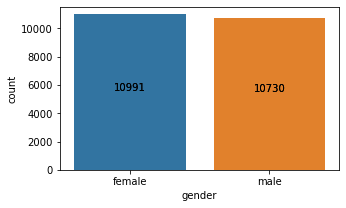

math_score        reading_score        writing_score       
             mean median          mean median          mean median
gender                                                            
female  64.162861   64.0     72.968247   73.0     72.980893   73.0
male    69.075862   69.0     65.880895   66.0     63.980429   64.0

In [25]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='gender')

tag = sns.countplot(data=df1b, x='gender')

for i in tag.patches:
    tag.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height() / 2), ha='center', va='bottom')

plt.show()

df1b.groupby(['gender'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

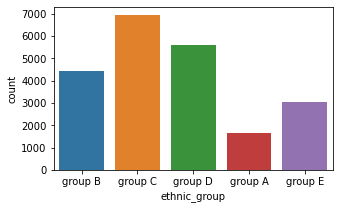

math_score        reading_score        writing_score       
                   mean median          mean median          mean median
ethnic_group                                                            
group A       62.974699   64.0     66.709639   66.0     65.120482   65.0
group B       63.536916   64.0     67.347934   68.0     65.994581   66.0
group C       64.735345   65.0     68.518391   69.0     67.122845   67.0
group D       67.669339   68.0     70.515945   71.0     71.032425   71.0
group E       75.210526   76.0     74.266100   75.0     72.694671   73.0

In [26]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='ethnic_group')

plt.show()

df1b.groupby(['ethnic_group'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

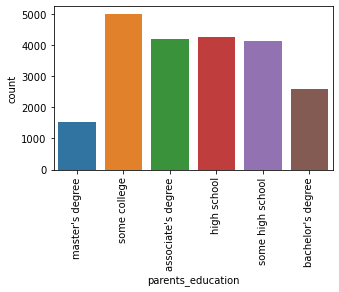

math_score        writing_score        reading_score       
                         mean median          mean median          mean median
parents_education                                                             
associate's degree  68.477651   69.0     70.403947   71.0     71.159534   71.0
bachelor's degree   70.691892   71.0     73.737452   74.0     73.440154   74.0
high school         64.262652   64.0     65.410965   66.0     67.183693   68.0
master's degree     72.284500   73.0     76.335513   77.0     75.785481   77.0
some college        66.507113   66.0     68.603086   69.0     69.285314   70.0
some high school    62.498429   63.0     63.634276   64.0     65.499154   65.0

In [27]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='parents_education')
plt.xticks(rotation=90)

plt.show()

df1b.groupby(['parents_education'])[['math_score','writing_score','reading_score']].agg(['mean','median'])

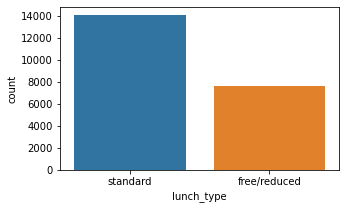

math_score        reading_score        writing_score       
                   mean median          mean median          mean median
lunch_type                                                              
free/reduced  58.879832   59.0     64.245577   64.0     62.746298   63.0
standard      70.765507   71.0     72.295103   73.0     71.669695   72.0

In [28]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='lunch_type')

plt.show()

df1b.groupby(['lunch_type'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

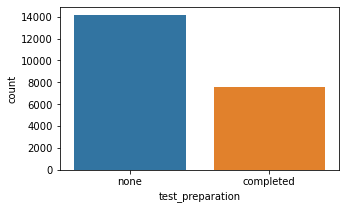

math_score        reading_score        writing_score       
                       mean median          mean median          mean median
test_preparation                                                            
completed         69.681842   70.0     73.863950   74.0     74.860499   75.0
none              64.947840   65.0     67.132234   67.0     65.175442   65.0

In [29]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='test_preparation')

plt.show()

df1b.groupby(['test_preparation'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

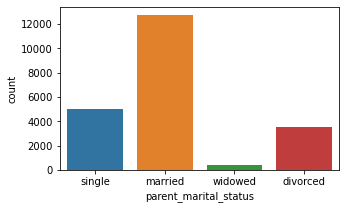

math_score        reading_score        writing_score  \
                            mean median          mean median          mean   
parent_marital_status                                                        
divorced               66.652371   67.0     69.700085   70.0     68.879012   
married                66.666536   67.0     69.429912   70.0     68.447669   
single                 66.246203   66.0     69.320344   70.0     68.446243   
widowed                67.849515   69.0     70.415049   71.0     69.368932   

                              
                      median  
parent_marital_status         
divorced                69.0  
married                 69.0  
single                  69.0  
widowed                 70.0

In [30]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='parent_marital_status')

plt.show()

df1b.groupby(['parent_marital_status'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

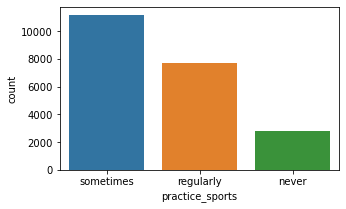

math_score        reading_score        writing_score       
                      mean median          mean median          mean median
practice_sports                                                            
never            64.487848   65.0     68.651638   69.0     66.876717   67.0
regularly        67.677549   68.0     69.946020   70.0     69.638918   70.0
sometimes        66.375916   66.0     69.345096   70.0     68.196891   68.0

In [31]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='practice_sports')

plt.show()

df1b.groupby(['practice_sports'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

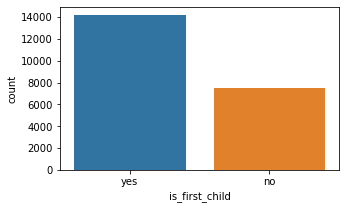

math_score        reading_score        writing_score       
                     mean median          mean median          mean median
is_first_child                                                            
no              66.418924   67.0     69.336848   70.0     68.483785   69.0
yes             66.679857   67.0     69.535775   70.0     68.561569   69.0

In [32]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='is_first_child')

plt.show()

df1b.groupby(['is_first_child'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

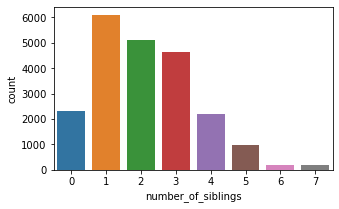

math_score        reading_score        writing_score       
                         mean median          mean median          mean median
number_of_siblings                                                            
0                   66.673744   67.0     69.643847   70.0     68.766031   69.0
1                   66.474546   67.0     69.331806   70.0     68.337698   69.0
2                   66.568543   67.0     69.459698   70.0     68.540498   69.0
3                   66.717838   67.0     69.512649   70.0     68.684757   69.0
4                   66.341353   66.0     69.462097   70.0     68.474807   69.0
5                   66.968880   67.0     69.680498   70.0     68.557054   69.0
6                   66.717073   66.0     68.726829   70.0     67.643902   68.0
7                   67.471154   69.0     70.447115   71.0     69.687500   70.0

In [33]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='number_of_siblings')

plt.show()

df1b.groupby(['number_of_siblings'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

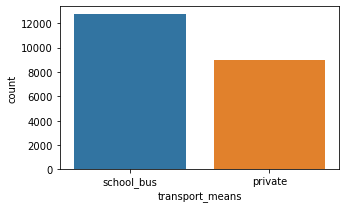

math_score        reading_score        writing_score       
                      mean median          mean median          mean median
transport_means                                                            
private          66.500947   67.0     69.469401   70.0     68.530487   69.0
school_bus       66.652392   67.0     69.465569   70.0     68.537725   69.0

In [34]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='transport_means')

plt.show()

df1b.groupby(['transport_means'])[['math_score','reading_score','writing_score']].agg(['mean','median'])

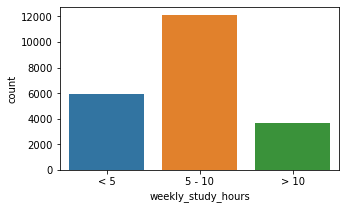

,math_score,reading_score,writing_score
weekly_study_hours,,,
5 - 10,66.904703,69.736183,68.760728
< 5,64.601423,68.323674,67.255042
> 10,68.740147,70.413428,69.841533


In [35]:
plt.subplots(1,1, figsize=(5,3))

sns.countplot(data=df1b, x='weekly_study_hours')

plt.show()

df1b.groupby(['weekly_study_hours'])[['math_score','reading_score','writing_score']].agg('mean','median')

In [36]:
## Drop 'is_first_child', 'number_of_siblings', and 'transport_means' columns

df1b = df1b.drop(columns=['is_first_child','number_of_siblings','transport_means'], axis=1)

In [37]:
## Create a copy of the dataset to be encoded

df1b_enc = df1b.copy()

df1b_enc.head()

,gender,ethnic_group,parents_education,lunch_type,test_preparation,parent_marital_status,practice_sports,weekly_study_hours,math_score,reading_score,writing_score
2,female,group B,master's degree,standard,none,single,sometimes,< 5,87,93,91
4,male,group C,some college,standard,none,married,sometimes,5 - 10,76,78,75
5,female,group B,associate's degree,standard,none,married,regularly,5 - 10,73,84,79
6,female,group B,some college,standard,completed,widowed,never,5 - 10,85,93,89
7,male,group B,some college,free/reduced,none,married,sometimes,> 10,41,43,39


In [38]:
## Define variables to dummy encode

columns_to_encode = ['ethnic_group','parents_education','parent_marital_status','practice_sports','weekly_study_hours']

for col in columns_to_encode:
    df1b_enc = pd.get_dummies(data=df1b_enc, columns=[col], drop_first=True, dtype=int)
    
## Convert selected variables into binary
    
df1b_enc['gender'] = np.where(df1b_enc['gender']=='male',1,0)
df1b_enc['lunch_type'] = np.where(df1b_enc['lunch_type']=='standard',1,0)
df1b_enc['test_preparation'] = np.where(df1b_enc['test_preparation']=='completed',1,0)

## Replace characters that could cause errors

df1b_enc.columns = df1b_enc.columns.str.replace(' ', '_').str.replace("'","").str.replace('>','_more_than_').str.replace('<','_less_than_')
    
df1b_enc.head()

,gender,lunch_type,test_preparation,math_score,reading_score,writing_score,ethnic_group_group_B,ethnic_group_group_C,ethnic_group_group_D,ethnic_group_group_E,parents_education_bachelors_degree,parents_education_high_school,parents_education_masters_degree,parents_education_some_college,parents_education_some_high_school,parent_marital_status_married,parent_marital_status_single,parent_marital_status_widowed,practice_sports_regularly,practice_sports_sometimes,weekly_study_hours__less_than__5,weekly_study_hours__more_than__10
2,0,1,0,87,93,91,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
4,1,1,0,76,78,75,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
5,0,1,0,73,84,79,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
6,0,1,1,85,93,89,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
7,1,0,0,41,43,39,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1


In [39]:
## Define the target variable

target_var = df1b_enc[['math_score','reading_score','writing_score']]

target_math = target_var['math_score']
target_reading = target_var['reading_score']
target_writing = target_var['writing_score']

## Define the predictor variable

predictor_var = df1b_enc.drop(['math_score','reading_score','writing_score'], axis=1)

## Split into train and test sets

X_train, X_test, y_math_train, y_math_test, y_reading_train, y_reading_test, y_writing_train, y_writing_test = train_test_split(predictor_var, target_math, 
                                                                                                                                target_reading, target_writing,
                                                                                                                                test_size=0.25, random_state=42)

In [40]:
## Create XGBoost models for each test scores

xgb_math = XGBRegressor()
xgb_reading = XGBRegressor()
xgb_writing = XGBRegressor()

## Hyperparameter tuning with GridSearch

params = {'max_depth': [4,5,6,7,8], 
          'min_child_weight': [1,2,3,4,5],
          'learning_rate': [0.1, 0.2, 0.3],
          'n_estimators': [75, 100, 125]
          }

scores = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

grid_math = GridSearchCV(xgb_math, param_grid=params, cv=5, scoring=scores)
grid_reading = GridSearchCV(xgb_reading, param_grid=params, cv=5, scoring=scores)
grid_writing = GridSearchCV(xgb_writing, param_grid=params, cv=5, scoring=scores)

grid_math.fit(X_train, y_math_train)
grid_reading.fit(X_train, y_reading_train)
grid_writing.fit(X_train, y_reading_train)

## Obtain the best hyperparameters

math_best_params = grid_math.best_params_
reading_best_params = grid_reading.best_params_
writing_best_params = grid_writing.best_params_


In [41]:
## Perform cross-validation and get predicted values

math_preds = cross_val_predict(grid_math.best_estimator_, X_train, y_math_train, cv=5)
reading_preds = cross_val_predict(grid_reading.best_estimator_, X_train, y_math_train, cv=5)
writing_preds = cross_val_predict(grid_writing.best_estimator_, X_train, y_math_train, cv=5)

In [42]:
## Print RMSE values

rmse_math = np.sqrt(mean_squared_error(y_math_train, math_preds))
rmse_reading = np.sqrt(mean_squared_error(y_reading_train, reading_preds))
rmse_writing = np.sqrt(mean_squared_error(y_writing_train, writing_preds))

print('RMSE Value for Math Scores:', rmse_math)
print('RMSE Value for Reading Scores:', rmse_reading)
print('RMSE Value for Writing Scores:', rmse_writing)

RMSE Value for Math Scores: 12.99992262815943
RMSE Value for Reading Scores: 14.743953052786756
RMSE Value for Writing Scores: 14.903747054828024


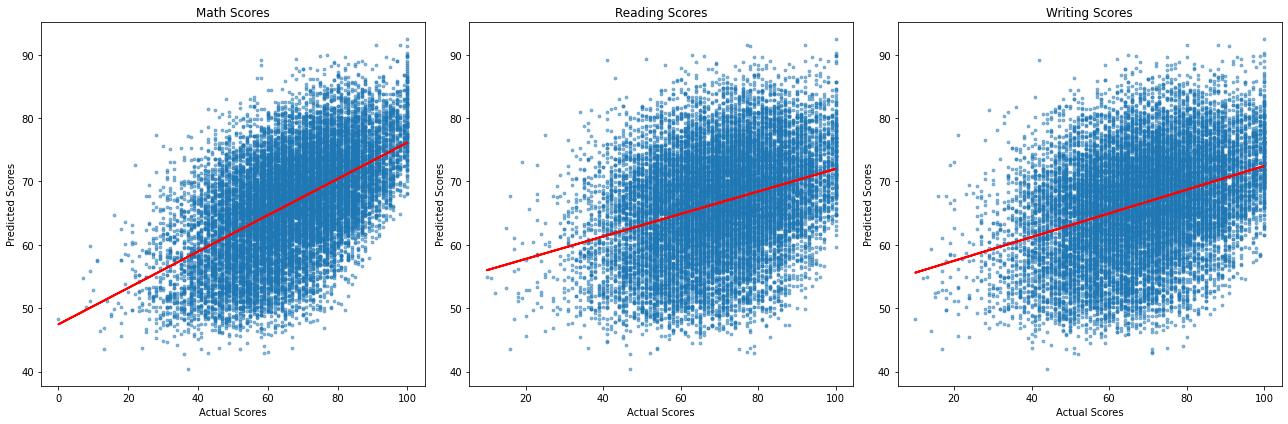

In [47]:
## Create a scatterplot to visualize actual versus predicted scores

test_scores = {'Math':(y_math_train, math_preds),
               'Reading':(y_reading_train, reading_preds),
               'Writing':(y_writing_train, writing_preds)}

plt.figure(figsize=(18,6))

for i, (subj_score_name,(actual_score, predicted_score)) in enumerate(test_scores.items()):
    plt.subplot(1,3, i+1)
    plt.scatter(actual_score, predicted_score, s=8, alpha=0.5)
    plt.title(f'{subj_score_name} Scores')
    plt.xlabel("Actual Scores")
    plt.ylabel("Predicted Scores")
    lr = LinearRegression()
    lr.fit(actual_score.values.reshape(-1,1), predicted_score)
    plt.plot(actual_score, lr.predict(actual_score.values.reshape(-1,1)), color='red', linewidth=2)

plt.savefig('wykresXGBoost.png')
    
plt.tight_layout()
plt.show()



In [44]:
## Create a table showing comparison between actual and predicted values of test results

comparison_table = pd.DataFrame({'Actual Math Score': y_math_train.values,
                                 'Predicted Math Score': math_preds,
                                 'Actual Reading Score': y_reading_train.values,
                                 'Predicted Reading Score': reading_preds,
                                 'Actual Writing Score': y_writing_train.values,
                                 'Predicted Writing Score': writing_preds
                                 })

comparison_table.head()

,Actual Math Score,Predicted Math Score,Actual Reading Score,Predicted Reading Score,Actual Writing Score,Predicted Writing Score
0,69,70.787338,69,70.787338,70,70.787338
1,90,69.141335,80,69.141335,81,69.141335
2,79,77.691803,78,77.691803,70,77.691803
3,55,68.424431,58,68.424431,60,68.424431
4,40,59.363270,49,59.363270,53,59.363270


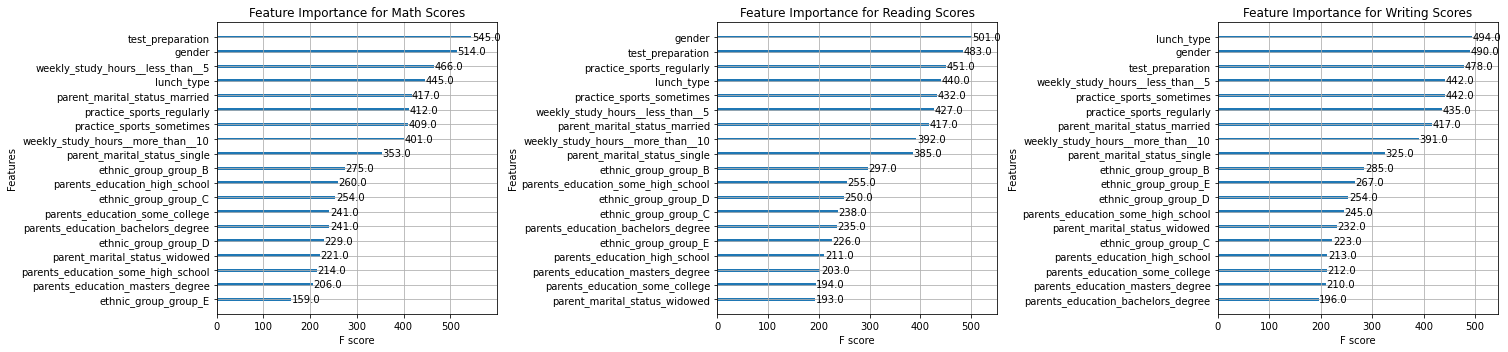

In [45]:
## Fit the models for each scores

xgb_math.fit(predictor_var, target_math)
xgb_reading.fit(predictor_var, target_reading)
xgb_writing.fit(predictor_var, target_writing)

## Plot feature importance for each scores

fig, ax = plt.subplots(1,3, figsize=(21,5))

xgb.plot_importance(xgb_math, importance_type='weight', title='Feature Importance for Math Scores', ax=ax[0])
xgb.plot_importance(xgb_reading, importance_type='weight', title='Feature Importance for Reading Scores', ax=ax[1])
xgb.plot_importance(xgb_writing, importance_type='weight', title='Feature Importance for Writing Scores', ax=ax[2])

plt.tight_layout()
plt.show()